In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SparkSession
from pyspark import SparkContext
import pandas as pd
import json
import glob
import os 

import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.config("spark.driver.memory", "30g")\
    .config("spark.driver.maxResultSize", '0').config("spark.executor.memory", "30g")\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1').config('spark.local.dir','/ada/tmp').getOrCreate()


In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType, FloatType

schema = StructType([
    StructField('date', StringType(), True),
    StructField('numOccurrences', StringType(), True),
    StructField('phase', StringType(), True),
    StructField('probas', ArrayType(ArrayType(StringType()))),
    StructField("qids", ArrayType(StringType()), True),
    StructField('speaker', StringType(), True),
    StructField('quotation', StringType(), True),
    StructField('quoteID', StringType(), True),
    StructField('urls', ArrayType(StringType()), True)
])

In [ ]:
quote_files = glob.glob("*")
quote_files = [k for k in quote_files if 'json' in k]


In [ ]:
quotes = spark.read.schema(schema).option("encoding", "UTF-8").json(quote_files)

# limit the dataset size for preliminary analysis and developing the pipeline
quotes.createOrReplaceTempView("data")


In [75]:
from tld import get_tld

def get_domain(urls):
    tlds = [get_tld(k, as_object=True).fld for k in urls]
    return tlds

def extract_smallest_qid(qids):
    try: 
        if len(qids) > 1:
            vals = [int(k[1:]) for k in qids]
            vals.sort()
            response = vals[0]
        else:
            response = int(qids[0][1:])
        return response
    except:
        print('fail')
        return None

get_domain_udf = udf(get_domain, ArrayType(StringType()))
extract_smallest_qid_udf = udf(extract_smallest_qid, IntegerType())

In [ ]:
import requests

response = requests.get(
    url="https://en.wikipedia.org/wiki/Glossary_of_climate_change",
)

print(response.status_code)

In [76]:
quotes = quotes.withColumn('domains', get_domain_udf('urls'))

In [38]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(response.content, 'html.parser')

climate_set = set()
for s in soup.find_all('dt', attrs={'glossary'}):
    climate_set.add(str(s.text))


In [40]:
climate_set = [k.lower() for k in climate_set]

In [505]:
# I manually remove a few words that do not fit 

climate_set3 = ['world climate report',
 'carbon offset',
 'iris hypothesis',
 'little ice age',
 'climate change feedback',
 'anthropogenic climate change',
 'solar variation',
 'season creep',
 'global warming period',
 'paleocene–eocene thermal maximum (petm)',
 'magnetosphere',
 'north atlantic deep water',
 'dendroclimatology',
 'climate crisis',
 'historical temperature record',
 'tex-86',
 'north atlantic oscillation',
 'global warming controversy',
 'cap and trade',
 'additionality',
 'stranded asset',
 'ice age',
 'antarctica cooling controversy',
 'global warming denial',
 'gulf stream',
 'anoxic event',
 'glacial motion',
 'arctic dipole anomaly',
 'milankovitch cycles',
 'ozone',
 'anti-greenhouse effect',
 'carbon footprint',
 'climatology',
 "earth's atmosphere",
 'tipping points in the climate system',
 'with measures (wem)',
 'irradiance',
 'atmospheric window',
 'climate legislation',
 'atmospheric sciences',
 'climate justice',
 'urban heat island',
 'ozone depletion',
 'nonradiative forcing',
 'el niño-southern oscillation (enso)',
 'glacial earthquake',
 'mode of variability',
 'methane',
 'climate stabilization wedge',
 'pacific decadal oscillation (pdo)',
 'desertification',
 'climate model',
 'ozone layer',
 'maunder minimum',
 'cool tropics paradox',
 'thermocline',
 'orbital forcing',
 'climate variability',
 'snowball earth',
 'thermohaline circulation',
 'climate resilience',
 'regime shift',
 'global climate model (gcm)',
 'global cooling',
 'holocene climatic optimum',
 'polar amplification',
 'adaptation',
 'ocean planet',
 'antarctic bottom water (abw)',
 'climate change',
 'blytt–sernander system',
 'invasive species',
 'climate sensitivity',
 'anthropogenic',
 'attribution of recent climate change',
 'kyoto protocol',
 'climate ethics',
 'mauna loa',
 'stratospheric aerosol injection',
 'carbon sequestration',
 'environmental crime',
 'climate movement',
 'climate change denial',
 'sea level rise',
 'global climate regime',
 'greenhouse gas',
 'atlantic multidecadal oscillation (amo)',
 'greenhouse gas inventory',
 'hockey stick graph',
 'forest dieback',
 'carbon dioxide',
 'paleoclimatology',
 'environmental migrant',
 'carbon diet',
 'instrumental temperature record',
 'keeling curve',
 'policies and measures (pams)',
 'without measures (wom)',
 'emission inventory',
 'antarctic oscillation (aao)',
 'anthropogenic global warming (agw)',
 'emission standards',
 'medieval warm period',
 'global warming potential',
 'carbon cycle',
 'with additional measures (wam)',
 'runaway greenhouse effect',
 'clathrate gun hypothesis',
 'enteric fermentation',
 'meteorology',
 'climate cycle',
 'fossil fuel',
 'detection and attribution',
 'cosmic rays',
 'ecotax',
 'climate forcing',
 'greenhouse effect',
 'interdecadal pacific oscillation (ipo)',
 'climate oscillation',
 'radiative forcing',
 'climate system',
 'mitigation of global warming',
 'intergovernmental panel on climate change (ipcc)',
 'nitrous oxide',
 'global dimming',
 'global warming (gw)',
 '100,000-year problem',
 'phenology',
 'arctic shrinkage',
 'climate change mitigation',
 'arctic oscillation (ao)',
 'emissions trading',
 'callendar effect',
 'carbon tax',
 'climate commitment',
 'emission intensity',
 'greenhouse debt',
 'ecosystem services',
 'arctic amplification',
 'carbon sink',
 'polar city']

In [506]:
quotes.createOrReplaceTempView("data")

In [507]:
climate_set2 = climate_set

In [508]:
string = ""
for vals in climate_set3:
    string += " LOWER(quotation) LIKE '%{}%' OR ".format(vals.replace("'", ''))
string = string[0:-4]


In [509]:
quotes2 = spark.sql("SELECT * FROM data WHERE {}".format(string))


In [510]:
climate_quotes = quotes2.toPandas()

In [511]:
climate_quotes['domains'] = climate_quotes['domains'].apply(lambda x: list(set(x)))

In [512]:
climate_quotes.to_csv('C:/Users/Venia/ada_projects/climate_quotes_full2.csv', index=False)

In [513]:
from sklearn.decomposition import LatentDirichletAllocation


In [514]:
from sklearn.feature_extraction.text import CountVectorizer

In [534]:
cv = CountVectorizer(ngram_range=(1,1), min_df = 50, max_df = 15000)

In [535]:
count_vecs = cv.fit_transform(climate_quotes.quotation.values)

In [536]:
lda = LatentDirichletAllocation(n_components=30, n_jobs = 60)
lda.fit(count_vecs)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=30, n_jobs=60,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [537]:
lda_scores = lda.transform(count_vecs)

In [538]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 45), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


In [539]:
tf_feature_names = cv.get_feature_names()

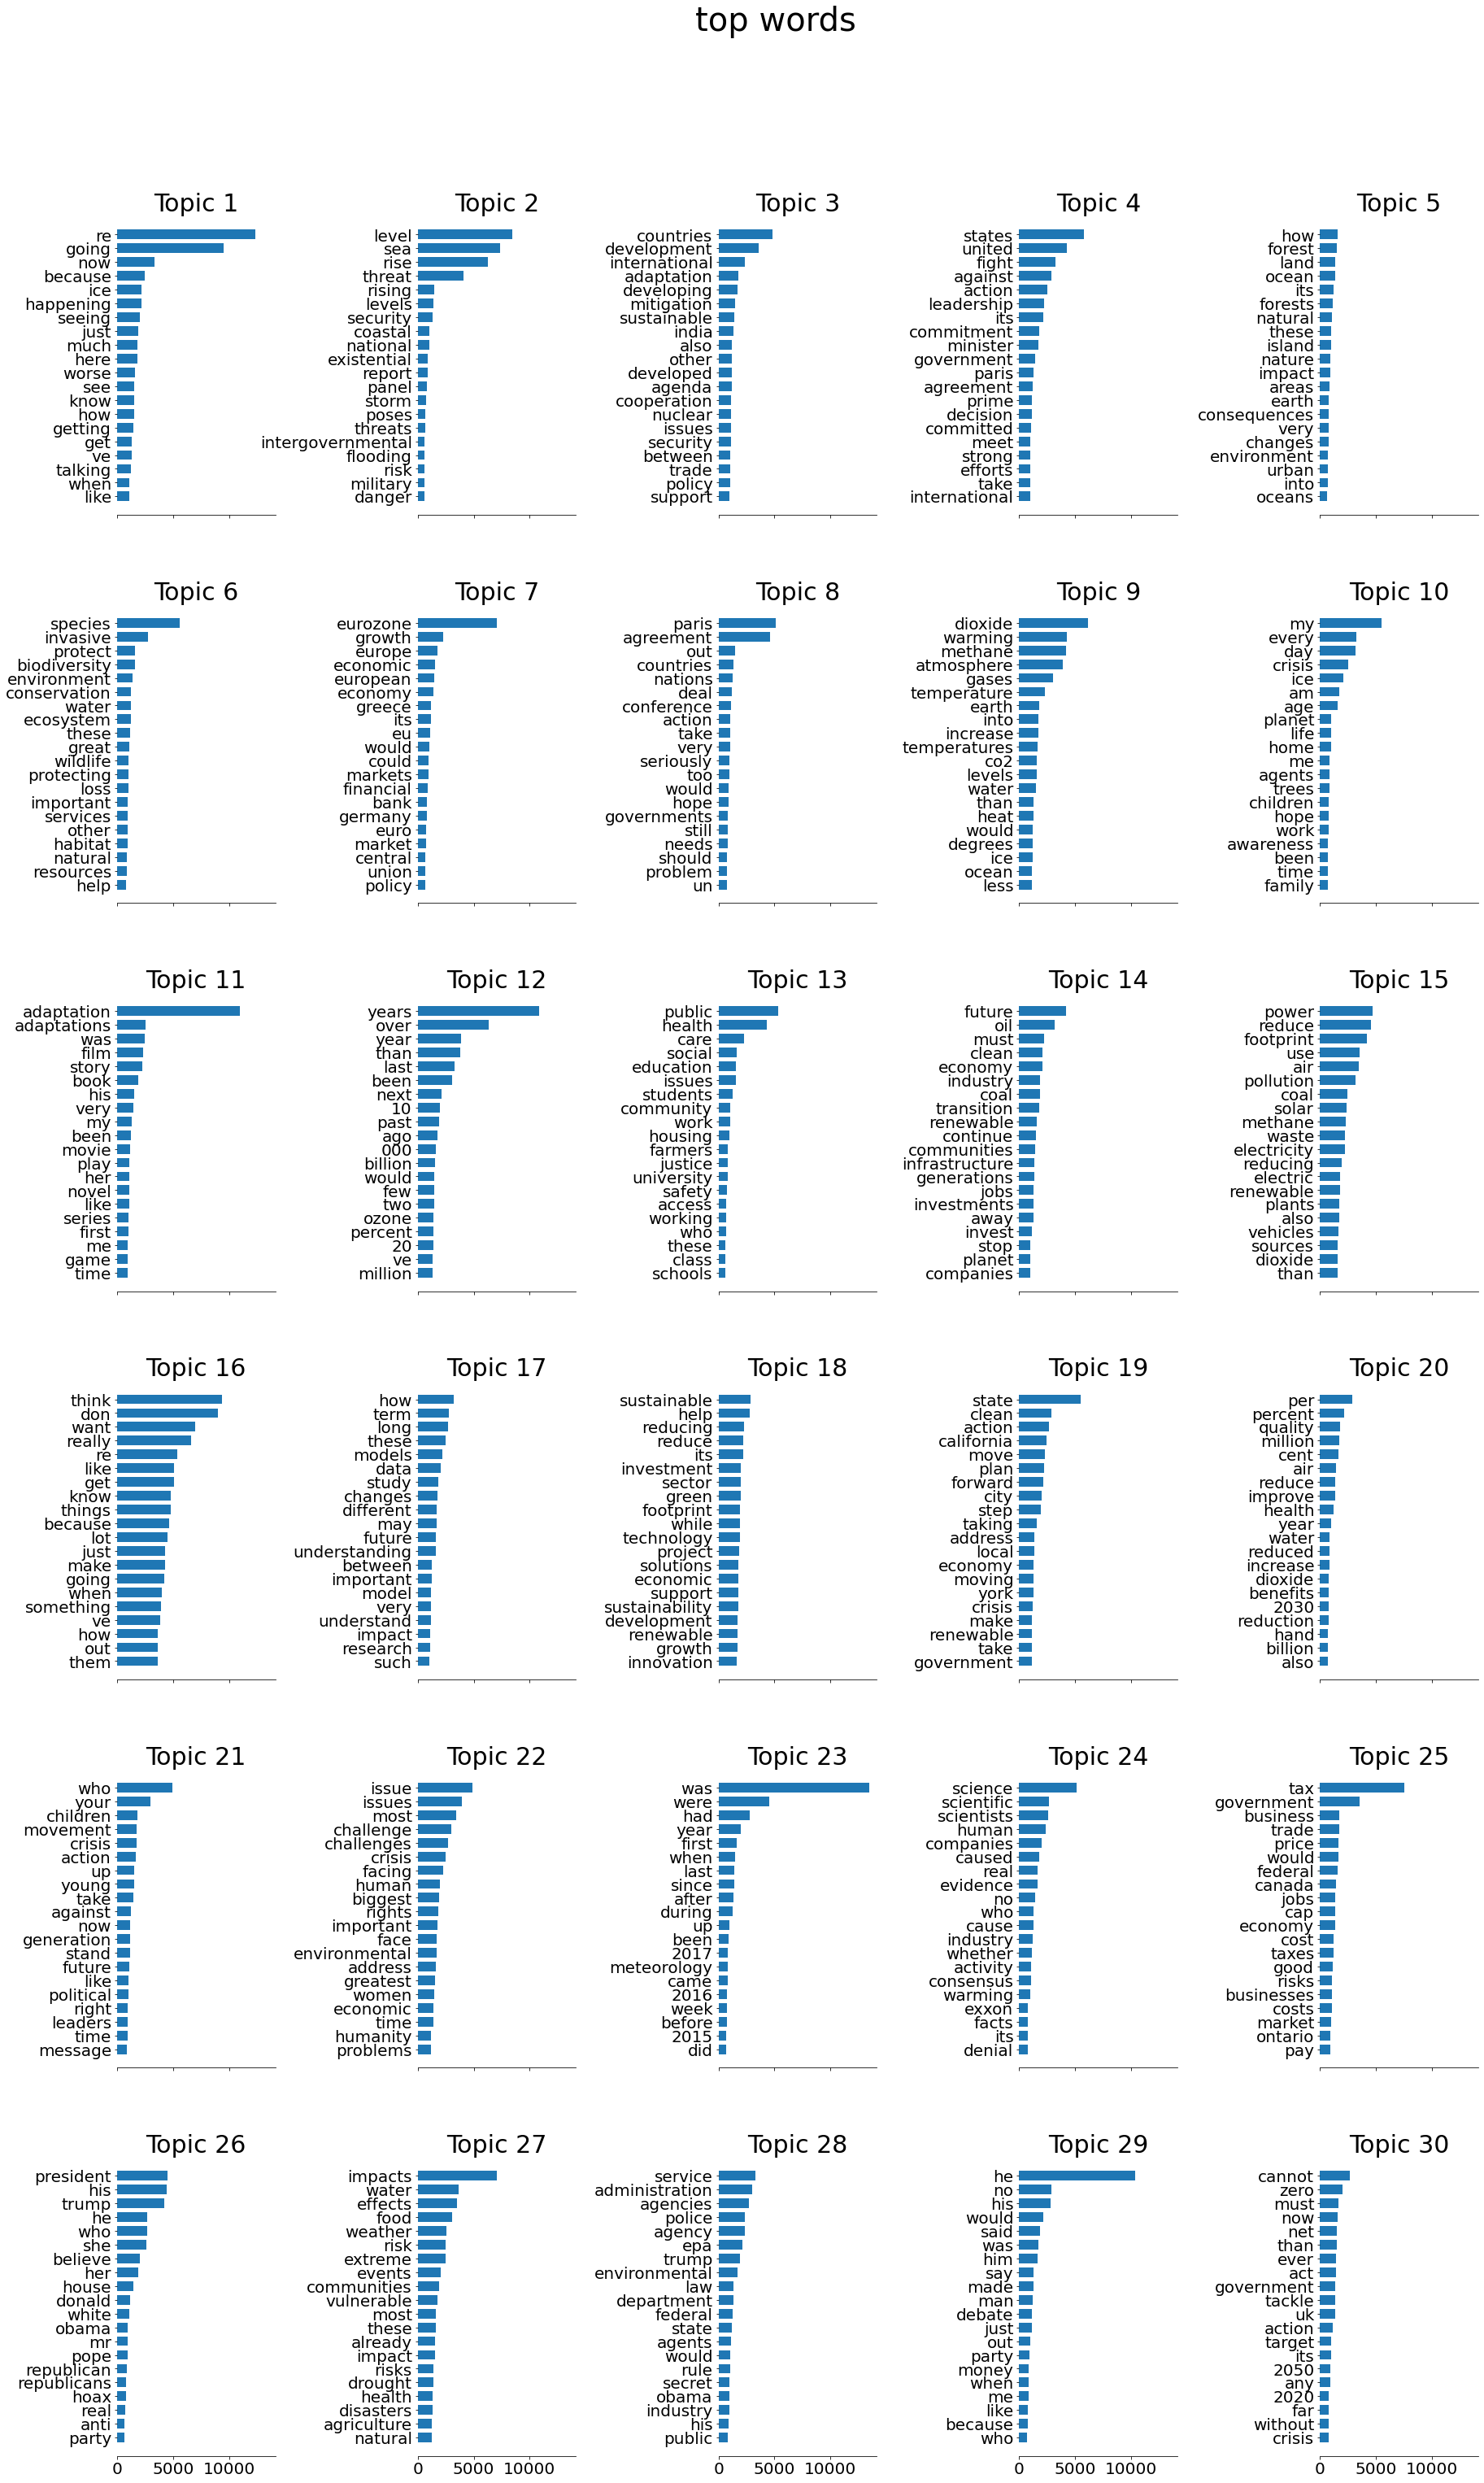

In [540]:
plot_top_words(lda, tf_feature_names, 20, "top words")

In [541]:
lda_topics = pd.read_csv("C:/Users/Venia/ada_projects/lda_topics.csv")

In [542]:
import numpy as np 
topix = [np.argmax(k) for k in lda_scores]

In [543]:
climate_quotes['id'] = topix

In [544]:
climate_quotes = climate_quotes.merge(lda_topics, on = 'id')

In [545]:
climate_quotes.groupby('topic')['id'].count()

topic
adaptation              10978
biodiversity             7129
challenges               9662
concern                  5359
developing world         7188
environment              5655
eurozone                 7720
future                   5109
gases                   11640
impact on vulnerable    11830
models                  11236
net zero                 5263
next generation          8249
paris                    6908
past tense               4456
power/footprint         14781
pronouns                 8001
reduction                4759
renewable                9548
science                  8396
sea level                5231
society                  5607
sustainability          15010
take action              7386
tax/trade                7787
trump                    6954
united states            7503
unknown                 34061
us admin.                7518
Name: id, dtype: int64

In [546]:
# convert to date
climate_quotes['date'] = pd.to_datetime(climate_quotes['date'])

In [547]:
# round to the nearest month (for aggregation)
climate_quotes['date_month'] = climate_quotes['date'].dt.strftime('%Y-%m')

In [548]:
climate_quotes.to_csv("C:/Users/Venia/ada_projects/climate_quotes_topics.csv",index=False)

In [549]:
# we'll build a racing bar chart to show how the most talked about topics change over time
for_racing_bar_chart = climate_quotes.groupby(['date_month','topic'])['id'].count().reset_index().sort_values(by='date_month')

In [550]:
for_racing_bar_chart = for_racing_bar_chart.pivot(columns = 'date_month', index='topic', values= 'id').fillna(0)

In [551]:
cols = for_racing_bar_chart.columns
for col in cols:
    for_racing_bar_chart[col+"_"] = (for_racing_bar_chart[col] - for_racing_bar_chart.mean(axis=1) ) / for_racing_bar_chart.std(axis=1)

In [552]:
cols_z = [k +"_" for k in cols]


In [409]:
# for_racing_bar_chart.drop(['2015-01-01','2020-05-01'],axis = 1, inplace=True)
# for_racing_bar_chart.columns = [k.strftime('%Y-%m') for k in for_racing_bar_chart.columns]

In [553]:
for_racing_bar_chart = for_racing_bar_chart[for_racing_bar_chart.index!='unknown']

In [554]:
for_racing_bar_chart.to_csv("C:/Users/Venia/ada_projects/racing_bar_chart3.csv",index=True)

In [455]:
# plot of 5 most important topics for each year
# note that this method can be improved IF we created an LDA for each year


In [555]:
climate_quotes['year'] = climate_quotes['date'].dt.year
year_data = climate_quotes.groupby(['year','topic'])['id'].count()

In [556]:
year_data.to_csv("C:/Users/Venia/ada_projects/topics_over_years3.csv")

In [557]:
from matplotlib.colors import LogNorm, Normalize


<AxesSubplot:xlabel='date_month', ylabel='topic'>

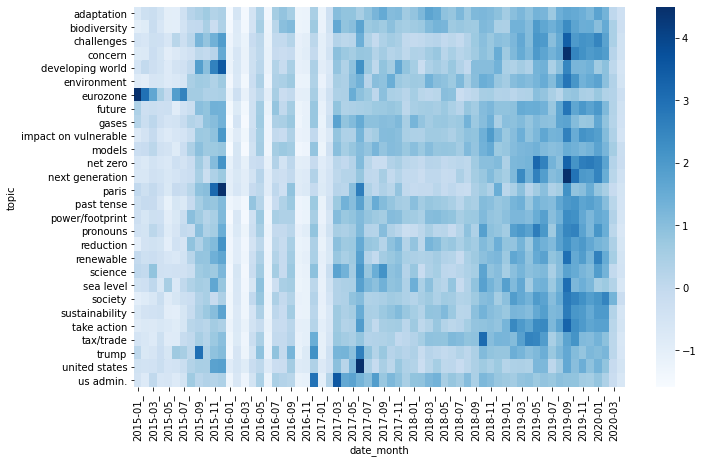

In [558]:
import seaborn as sns
# heatmap
fig,ax=plt.subplots(figsize=(11,7))
sns.heatmap(for_racing_bar_chart[cols_z], ax = ax, yticklabels=True, cmap="Blues", vmax = 4.5)


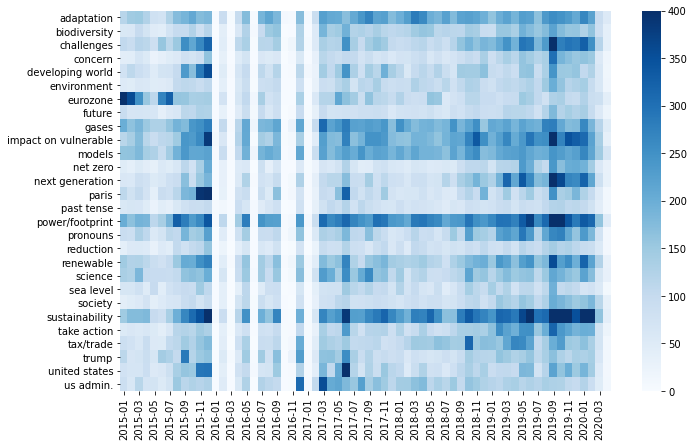

In [574]:
import seaborn as sns
# heatmap
fig,ax=plt.subplots(figsize=(11,7))
sns.heatmap(for_racing_bar_chart[cols], ax = ax, yticklabels=True, cmap="Blues", vmax = 400)
ax.set_ylabel('')    
ax.set_xlabel('')
plt.savefig('C:/Users/Venia/ada_projects/topic_evolution.png', dpi = 300)

In [561]:
# explode on the domains to later groupby for the embedding
domains_exploded = climate_quotes.explode('domains')

In [562]:
issues_by_news_site = domains_exploded.groupby(['domains', 'topic','id'])['id'].count()
issues_by_news_site.head(5)

domains      topic            id
1011now.com  next generation  20    2
             paris            7     1
             power/footprint  14    2
             pronouns         28    1
             trump            25    3
Name: id, dtype: int64

In [563]:
issues_by_news_site.name = 'count' 

In [564]:
# we'll use this when defining the vector for climate topics
issues_by_news_site.to_csv("C:/Users/Venia/ada_projects/issues_by_news_site2.csv")

In [565]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 45), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


In [567]:
vals = []
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[: -10 - 1 : -1]
    top_features = [tf_feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    vals.append({'id': topic_idx, 'top_features':top_features, 'weights':weights})

In [568]:
topic_word_scores = pd.DataFrame(vals).explode(['top_features','weights'])


In [502]:
lda_topics.merge(topic_word_scores).to_csv("C:/Users/Venia/ada_projects/topic_scores.csv", index= False)